<a href="https://colab.research.google.com/github/vishvesh-coreteams/vishvesh/blob/main/prediction_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



from google.colab import files
uploaded = files.upload()


# Load dataset
df = pd.read_csv("gpt_synthetic_medical_sales.csv")

df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Creating lag features
df["lag_1"] = df.groupby("productId")["quantity"].shift(1)
df["lag_2"] = df.groupby("productId")["quantity"].shift(2)
df["lag_3"] = df.groupby("productId")["quantity"].shift(3)

# Rolling averages
df["rolling_mean_3"] = df.groupby("productId")["quantity"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df["rolling_mean_6"] = df.groupby("productId")["quantity"].transform(lambda x: x.rolling(window=6, min_periods=1).mean())

# Seasonal indicators
df["is_winter"] = df["month"].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df["is_summer"] = df["month"].apply(lambda x: 1 if x in [6, 7, 8] else 0)

df.fillna(0, inplace=True)

# Define features and target
features = ["year", "month", "lag_1", "lag_2", "lag_3", "rolling_mean_3", "rolling_mean_6", "is_winter", "is_summer"]
X = df[features]
y = df["quantity"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predictions
y_pred = ridge_model.predict(X_test)

# Compute confidence intervals
pred_std = np.std(y_pred - y_test)
lower_bound = y_pred - 1.96 * pred_std
upper_bound = y_pred + 1.96 * pred_std

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score = ridge_model.score(X_test, y_test)

print(f"Model Accuracy:\nMAE: {mae}\nRMSE: {rmse}\nR² Score: {r2_score}")

def predict_demand_range(product_id, month, year):
    product_data = df[df["productId"] == product_id].sort_values("date").iloc[-1]
    input_data = pd.DataFrame({
        "year": [year], "month": [month], "lag_1": [product_data["quantity"]],
        "lag_2": [product_data["lag_1"]], "lag_3": [product_data["lag_2"]],
        "rolling_mean_3": [product_data["rolling_mean_3"]], "rolling_mean_6": [product_data["rolling_mean_6"]],
        "is_winter": [1 if month in [12, 1, 2] else 0], "is_summer": [1 if month in [6, 7, 8] else 0]
    })
    predicted_quantity = ridge_model.predict(input_data)[0]
    lower = max(0, round(predicted_quantity - 1.96 * pred_std))
    upper = round(predicted_quantity + 1.96 * pred_std)
    return lower, upper

# Example usage
product_id = 2
month = 3
year = 2024
print(f"Predicted demand range for product {product_id} in {month}/{year}: {predict_demand_range(product_id, month, year)}")


Saving gpt_synthetic_medical_sales.csv to gpt_synthetic_medical_sales (4).csv
Model Accuracy:
MAE: 12.532554132219373
RMSE: 23.205087004148464
R² Score: 0.8689935269867798
Predicted demand range for product 2 in 3/2024: (16, 107)


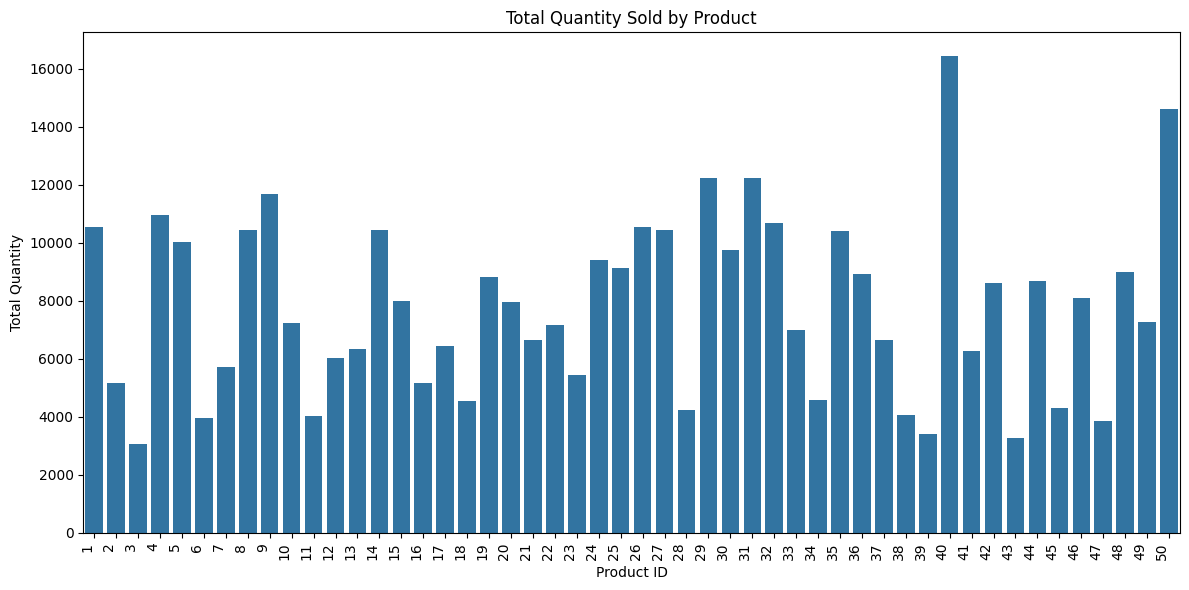

In [24]:
# Grouping data
product_quantities = df.groupby('productId')['quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='productId', y='quantity', data=product_quantities)
plt.title('Total Quantity Sold by Product')
plt.xlabel('Product ID')
plt.ylabel('Total Quantity')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()
